In [1]:
import numpy as np
from scipy import integrate
import torch

import matplotlib
import matplotlib.pyplot as plt

from probability_distribution import mu_gaussians, mu_display2D, mu_normalize
from fourier_functions import Fourier_Functions, Fourier_Functions_Visualize2D
import pickle 

2.383759522614545


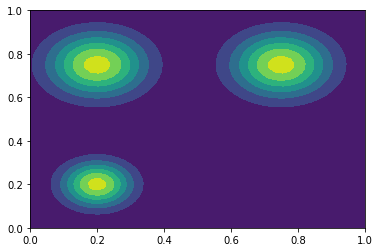

In [2]:
U_shape = (1,1)
p1 = mu_gaussians([(0.2, 0.01), (0.75, 0.02), (np.array([0.2, 0.75]), 0.02)], U_shape)
p1 = mu_normalize(p1, U_shape)
print(p1(np.array([0.2,0.3])))
mu_display2D(p1, U_shape)


In [3]:
mu = p1
K = 5
ff = Fourier_Functions(mu, U_shape, K, compute_mu=False, printProgress=True)

# mu_k = {}
# for k in ff:
#     mu_k[k] = ff[k]['mu_k']

# with open(f'mu_k{K}.pkl', 'wb') as handle:
#     pickle.dump(mu_k, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'mu_k{K}.pkl', 'rb') as handle:
    mu_k = pickle.load(handle)

for k in ff:
    ff[k]['mu_k'] = mu_k[k]
    print(f"{k}: ", ff[k]['mu_k'])

Fourier Functions (mu, U_shape= (1, 1) , K= 5 )...
Computing constants (new_k, h_k, lambda_k)...
Computing torch fourier functions (f_k, df_k)...
Computing casadi fourier function (casadi_f_k)...
Aggregating all constants and functions into one dict...
Done.
(0, 0):  0.9999999999999999
(0, 1):  -0.5307702669535661
(0, 2):  0.07295736998227048
(0, 3):  0.44939686238898763
(0, 4):  -0.6784934108382644
(1, 0):  0.272167236462443
(1, 1):  0.20830809711152895
(1, 2):  0.08856456294643258
(1, 3):  -0.04983881639462763
(1, 4):  -0.2055265333995762
(2, 0):  0.20906317912764094
(2, 1):  -0.033773322622715554
(2, 2):  0.030287152637313797
(2, 3):  0.056283048457482075
(2, 4):  -0.14641313232619976
(3, 0):  0.0659655868450172
(3, 1):  -0.21067685557518862
(3, 2):  -0.029401282741966687
(3, 3):  0.1153688622470077
(3, 4):  -0.03436830407887444
(4, 0):  -0.6409380522961304
(4, 1):  0.2837572822713951
(4, 2):  -0.05775266686456321
(4, 3):  -0.2604959747190519
(4, 4):  0.43820976763906505


In [4]:
from mm_agent import MMAgent1
from casadi_agent import CasadiAgent
from communication import GlobalBroadcastingSystem, LocalAveragingSystem, LocalStaticConsensusSystem, LocalDynamicConsensusSystem
from ergodic_agents import Agent, AgentSystem

n = len(U_shape)
all_k = list(np.ndindex(*[K]*n))
agents = [MMAgent1(i, np.random.uniform(0, U_shape), 0.5, all_k, U_shape, ff, eps=1e-5) for i in range(5)]

print("system")

systems = []
comm_range = 0.3 
comm_timestep = 0.1
for system in [AgentSystem, GlobalBroadcastingSystem, LocalAveragingSystem, LocalStaticConsensusSystem, LocalDynamicConsensusSystem]:
    systems.append(system(agents, mu, U_shape, ff, K))
for system in systems[2:]:
    system.set_communication_range(comm_range)
    system.set_communication_timestep(comm_timestep)


system


In [5]:
t = 0
delta_t = 0.1
for i in range(1000):
    t = i * delta_t
    for system in systems:
        system.evolve(t, delta_t)


oh no at time  1.2000000000000002
oh no at time  1.5
oh no at time  1.9000000000000001
oh no at time  2.0
oh no at time  2.0
oh no at time  2.2
oh no at time  2.2
oh no at time  2.2
oh no at time  2.2
oh no at time  2.3000000000000003
oh no at time  2.3000000000000003
oh no at time  2.4000000000000004
oh no at time  2.4000000000000004
oh no at time  2.7
oh no at time  2.7
oh no at time  2.7
oh no at time  2.8000000000000003
oh no at time  2.8000000000000003
oh no at time  2.8000000000000003
oh no at time  2.9000000000000004
oh no at time  2.9000000000000004
oh no at time  3.2
oh no at time  3.2
oh no at time  3.3000000000000003
oh no at time  3.5
oh no at time  3.6
oh no at time  3.6
oh no at time  3.7
oh no at time  3.8000000000000003
oh no at time  3.9000000000000004
oh no at time  4.0
oh no at time  4.0
oh no at time  4.1000000000000005
oh no at time  4.3
oh no at time  4.4
oh no at time  4.5
oh no at time  4.6000000000000005
oh no at time  5.0
oh no at time  5.1000000000000005
oh n

In [6]:
for system in systems:
    for k in system.all_k_bands:
        plt.figure()
        for i, agent in enumerate(system.agents):
            plt.plot([agent.system_c_k_log[i][k] for i in len(agent.system_c_k_log)], label=f"agent{i}")
        plt.plot([system.c_k_log[i][k] for i in len(system.c_k_log)], "actual average")
        plt.title(system.system_type + str(k))

TypeError: 'int' object is not iterable

<Figure size 432x288 with 0 Axes>

In [ ]:
for system in systems:
    system.visualize2d(filename=system.system_type+"_K=5", additional_title="TEST", plot_c_k=False)

In [8]:
def fourier_coefficient2distribution(ff, k_bands, c_k=None):
    def dist(x):
        res = 0
        for k in k_bands:
            if c_k is None:
                coeff_k = ff[k]['mu_k']
            else:
                coeff_k = c_k[k]
            res += coeff_k*ff[k]['f_k'](x)
        return res
    return dist

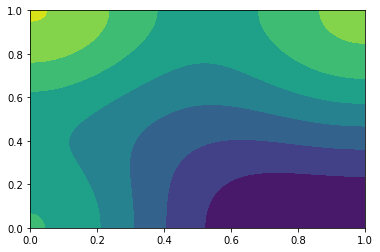

In [9]:
recon_mu = fourier_coefficient2distribution(ff, all_k)
mu_display2D(recon_mu, U_shape)

In [11]:
# i = 10
for i in [0, 20, 40, 60, 80, 100]:
    print("i: ", i)
    print(agent1.x_log[i])
    recon_c_k = fourier_coefficient2distribution(ff, all_k, agent1.c_k_log[i])
    mu_display2D(recon_c_k, U_shape)

i:  0
[0.2 0.3]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
i = -1
print(agent1.x_log[i])
recon_c_k = fourier_coefficient2distribution(ff, all_k, agent1.c_k_log[i])
mu_display2D(recon_c_k, U_shape)

In [ ]:
def mu_time(t):
    return mu_gaussians([(np.array([0.2+0.05*t, 0.4]), 0.1/t), (np.array([0.8-0.1*t, 0.8]), 0.05), (np.array([0.8, 0.2]), 0.025)], (1,1))

for i in range(3):
    mu_display2D(mu_time(i+1), (1,1))